# Week4 assignment

In this task you have to design a prediction model that is able to discriminate the basetracks beloning to the electromagnetic showers from the background basetracks. The goal is to get the best possible score (ROC AUC). 

## The data files:
At `Week4` Release of this repository you can find the following files:

https://github.com/hse-aml/hadron-collider-machine-learning/releases/download/Week_4/training.tgz - archive with brick volumes filled with labeled basetracks
https://github.com/hse-aml/hadron-collider-machine-learning/releases/download/Week_4/test.h5.gz - volume with basetracks you have to discriminate

Follow the details at `index.ipynb`

Each BaseTrack (BT) is described by:

- Coordinates: (X, Y, Z)

- Angles in the brick-frame: (TX, TY)

After the 'add_neighbours' we add dX,dY,dZ,dTX,dTY (distance from the origin) and group close tracks from neighbour plates into pairs.

In [1]:
# Sample solution is based on nontebooks by Artem Borzov

import numpy as np
import pandas as pd
import seaborn as sns
import scipy
import tables as tb
from mpl_toolkits.mplot3d import Axes3D
from tqdm import tqdm
from sklearn.neighbors import BallTree, KDTree, DistanceMetric
import glob
import gc

%pylab inline

Populating the interactive namespace from numpy and matplotlib


# Load Datasets

In [2]:
train = pd.read_hdf('data/training/open30.h5') # pick just a single brick
test = pd.read_hdf('data/test.h5')

In [3]:
test = test.reset_index(drop=True)

In [4]:
test.head()

,TX,TY,X,Y,Z,data_ind
0,0.087240,0.119438,86536.218750,62988.312500,56892.0,0
1,-0.380208,0.198382,93346.765625,58062.937500,14223.0,0
2,-0.348549,-0.099981,66129.578125,23038.673828,46548.0,0
3,0.585342,-0.126879,68825.523438,55186.625000,45255.0,0
4,0.038579,-0.131510,36366.941406,47564.878906,9051.0,0


In [5]:
train.head()

,TX,TY,X,Y,Z,event_id,signal,data_ind
0,-0.248382,0.072824,37014.070312,38318.898438,31032.0,-999.0,0.0,21
1,0.768548,0.490205,46626.425781,15151.117188,72408.0,188918.0,1.0,21
2,-0.132050,-0.049405,54031.640625,69132.320312,60771.0,-999.0,0.0,21
3,0.260584,0.207106,56653.531250,35025.765625,43962.0,-999.0,0.0,21
4,0.267597,0.111272,42231.714844,47199.027344,20688.0,-999.0,0.0,21


Let's see how showers look like inside one data_ind

In [6]:
CMAP = sns.diverging_palette(220, 20, s=99, as_cmap=True, n=2500, center="dark")

def plot3D(X, target, elev=0, azim=0, title=None, sub=111):
    x = X[:, 0]
    y = X[:, 1]
    z = X[:, 2]
    
    fig = plt.figure(figsize=(12, 8))
    ax = Axes3D(fig)
    mappab = ax.scatter(x, y, z, c=target, cmap=CMAP)

    if title is not None:
        ax.set_title(title)
    ax.set_xlabel('Component 1')
    ax.set_ylabel('Component 2')
    ax.set_zlabel('Component 3')

# Этот инструмент позволяет менять точку зрения
# This tool allows you to change the point of view 
    ax.view_init(elev=elev, azim=azim)
    fig.colorbar(mappable=mappab, label='Target variable')
    plt.show()
    
feat_XY = ['TX', 'TY', 'X', 'Y']

In [7]:
first = train.loc[train.data_ind == 21, :]

<ipython-input-6-74ad5991f22c>:9: MatplotlibDeprecationWarning: Axes3D(fig) adding itself to the figure is deprecated since 3.4. Pass the keyword argument auto_add_to_figure=False and use fig.add_axes(ax) to suppress this warning. The default value of auto_add_to_figure will change to False in mpl3.5 and True values will no longer work in 3.6.  This is consistent with other Axes classes.
  ax = Axes3D(fig)


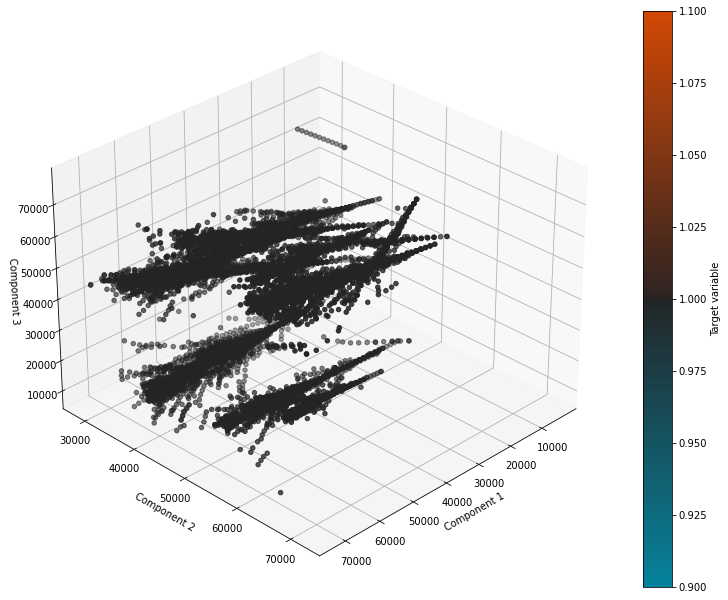

In [8]:
plot3D(first.loc[first.signal==1, ['Z', 'X', 'Y']].values,
       first.loc[first.signal==1].signal.values, elev=30, azim=45)

<ipython-input-6-74ad5991f22c>:9: MatplotlibDeprecationWarning: Axes3D(fig) adding itself to the figure is deprecated since 3.4. Pass the keyword argument auto_add_to_figure=False and use fig.add_axes(ax) to suppress this warning. The default value of auto_add_to_figure will change to False in mpl3.5 and True values will no longer work in 3.6.  This is consistent with other Axes classes.
  ax = Axes3D(fig)


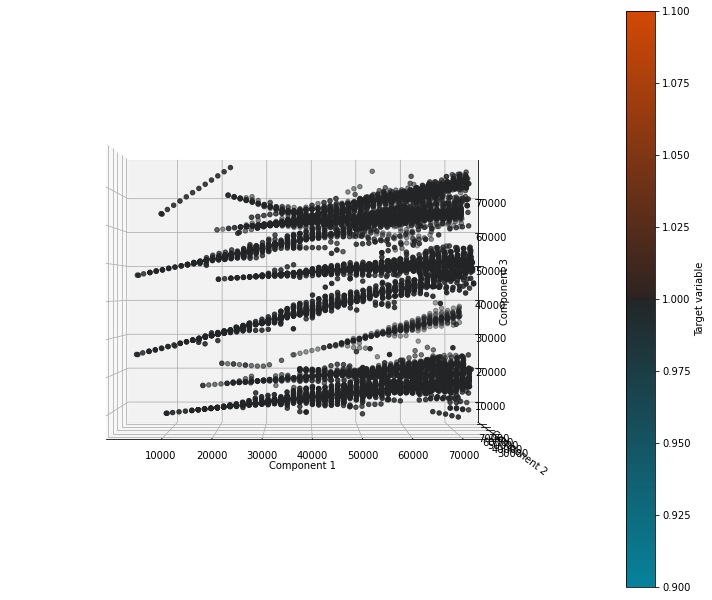

In [9]:
plot3D(first.loc[first.signal==1, ['Z', 'X', 'Y']].values,
       first.loc[first.signal==1].signal.values, elev=0, azim=270)

## Let's take a look at basetrack distribution along the axis

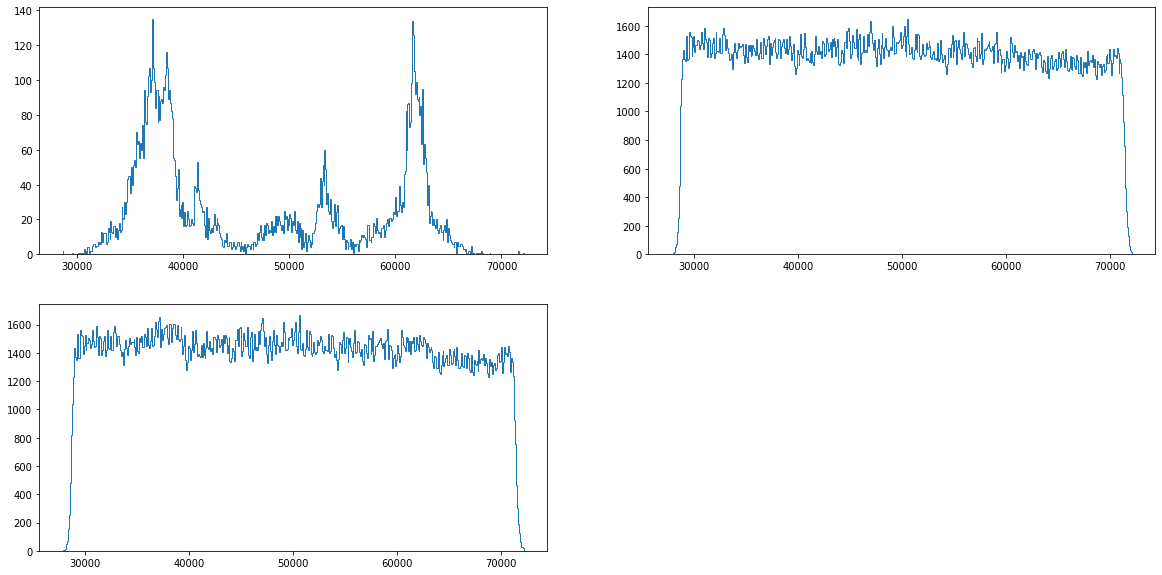

In [10]:
axis = 'X'

fig = plt.figure(figsize = [20, 10])
fig.add_subplot(221)
plt.hist(first.loc[first.signal == 1, axis], bins=500, histtype='step') #signal
fig.add_subplot(222)
plt.hist(first.loc[first.signal == 0, axis], bins=500, histtype='step') #Background
fig.add_subplot(223)
values_X = plt.hist(first.loc[:, axis], bins=500, histtype='step')
plt.show()

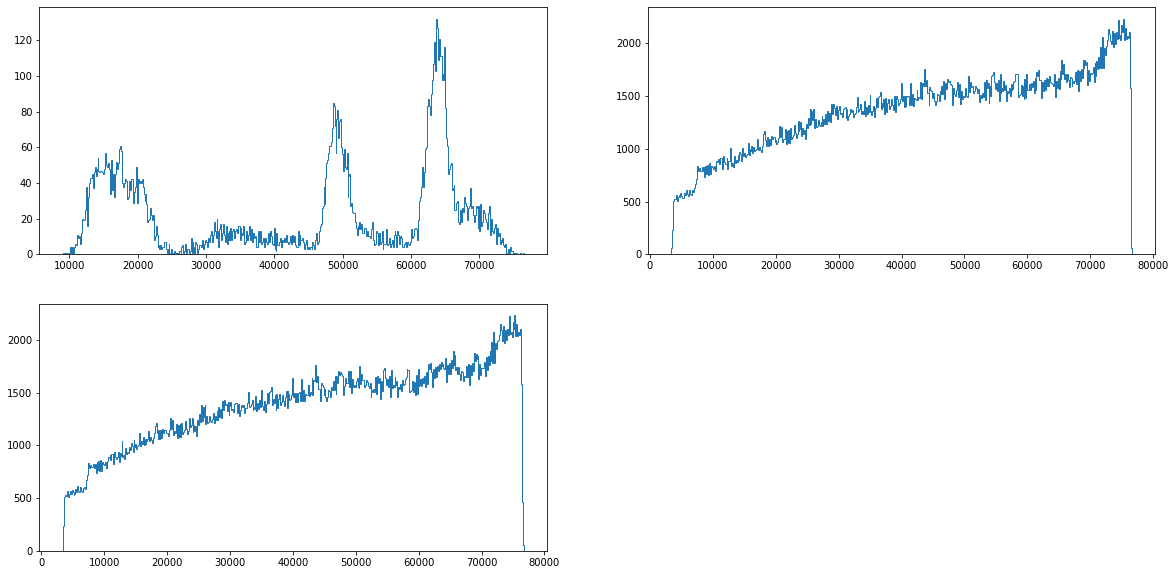

In [11]:
axis = 'Y'

fig = plt.figure(figsize = [20, 10])
fig.add_subplot(221)
plt.hist(first.loc[first.signal == 1, axis], bins=500, histtype='step') #signal
fig.add_subplot(222)
plt.hist(first.loc[first.signal == 0, axis], bins=500, histtype='step') #Background
fig.add_subplot(223)
values_X = plt.hist(first.loc[:, axis], bins=500, histtype='step')
plt.show()

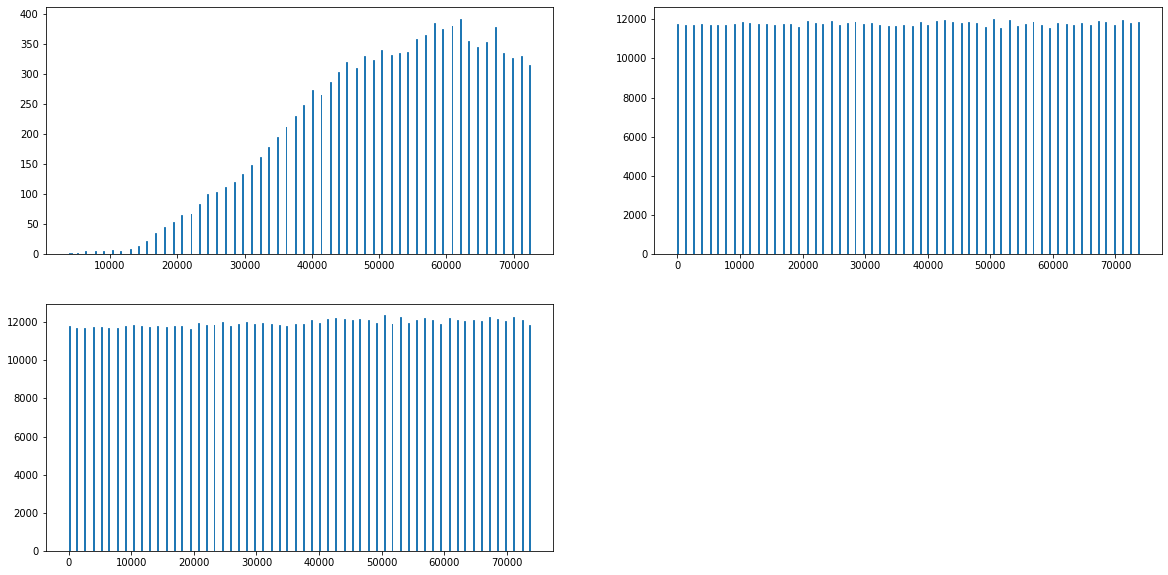

In [12]:
axis = 'Z'

fig = plt.figure(figsize = [20, 10])
fig.add_subplot(221)
plt.hist(first.loc[first.signal == 1, axis], bins=500, histtype='step')
fig.add_subplot(222)
plt.hist(first.loc[first.signal == 0, axis], bins=500, histtype='step')
fig.add_subplot(223)
values_X = plt.hist(first.loc[:, axis], bins=500, histtype='step')
plt.show()

# Let's group close tracks from neighbour plates into pairs

In [13]:
def add_neighbours(df, k, metric='minkowski'):
    res = []
    
    for data_ind in tqdm(np.unique(df.data_ind)):
        ind = df.loc[df.data_ind == data_ind].copy()
        #как будет замечено, 1293 - это расстояние между слайсами по Z
        #as will be seen, 1293 is the distance between slices in Z 
        ind[['TX', 'TY']] *= 1293
        values = np.unique(ind.Z)
        
        for j in range(1, len(values)):
            z, z_next = (ind.loc[ind.Z == values[j-1]].copy(),
                         ind.loc[ind.Z == values[j]].copy())
            
            b_tree = BallTree(z_next[feat_XY], metric=metric)
            d, i = b_tree.query(z[feat_XY], k=min(k, len(z_next)))
            
            for m in range(i.shape[1]):
                data = z_next.iloc[i[:, m]]
                z_copy = z.copy()
                for col in feat_XY + ['Z']:
                    z_copy[col + '_pair'] = data[col].values
                res.append(z_copy)
            
        res.append(z_next)
        
    res = pd.concat(res)
    for col in feat_XY + ['Z']:
        res['d' + col] = res[col].values - res[col + '_pair'].values
    return res

def balance_train(df, k):
    data = add_neighbours(df, k=k)
    noise = data.event_id == -999
    signal, not_signal = data.loc[np.logical_not(noise)], data.loc[noise]
    noise_part = not_signal.sample(len(signal))
    return pd.concat([signal, noise_part]).reset_index(drop=True)

In [14]:
train = []
for file in glob.glob('data/training/open*.h5')[:5]: # just 5 bricks 3000000
    train.append(balance_train(pd.read_hdf(file).sample(2000000), k=3))
train = pd.concat(train)

#def standardize_function(X_train):
#    df_scaled = pd.DataFrame(MinMaxScaler().fit_transform(X_train), columns = X_train.columns)
#    return df_scaled

#train = standardize_function(train)

100%|██████████| 10/10 [00:12<00:00,  1.23s/it]


In [15]:
train.head()

,TX,TY,X,Y,Z,event_id,signal,data_ind,TX_pair,TY_pair,X_pair,Y_pair,Z_pair,dTX,dTY,dX,dY,dZ
0,-89.869354,99.934273,47168.984375,11332.085938,6465.0,183825.0,1.0,261,-65.799965,136.888519,47078.632812,11437.242188,7758.0,-24.069389,-36.954247,90.351562,-105.156250,-1293.0
1,-89.869354,99.934273,47168.984375,11332.085938,6465.0,183825.0,1.0,261,-257.156921,-102.230217,47080.808594,11854.411133,7758.0,167.287567,202.164490,88.175781,-522.325195,-1293.0
2,-89.869354,99.934273,47168.984375,11332.085938,6465.0,183825.0,1.0,261,-470.299896,15.236524,47641.800781,10934.351562,7758.0,380.430542,84.697746,-472.816406,397.734375,-1293.0
3,-65.799965,136.888519,47078.632812,11437.242188,7758.0,183825.0,1.0,261,-23.452990,-11.927730,47041.351562,11478.375000,9051.0,-42.346977,148.816254,37.281250,-41.132812,-1293.0
4,-65.799965,136.888519,47078.632812,11437.242188,7758.0,183825.0,1.0,261,-293.282013,-114.285950,46746.000000,11636.132812,9051.0,227.482056,251.174469,332.632812,-198.890625,-1293.0


# Building a model

In [16]:
y_train = train.signal
X_train = train.drop(['event_id', 'signal', 'data_ind'], axis=1)
train = None
gc.collect()

0

In [17]:
# import os

# mingw_path = 'C:\\Program Files\\mingw-w64\\x86_64-7.2.0-posix-seh-rt_v5-rev1\\mingw64\\bin'

# os.environ['PATH'] = mingw_path + ';' + os.environ['PATH']
if False:
    import xgboost as xg
    from xgboost import XGBClassifier
    from sklearn.model_selection import StratifiedKFold, GridSearchCV

In [18]:
if False:
    from tune_sklearn import TuneSearchCV

    class XGBClassifier_tmp(XGBClassifier):
        def predict(self, X):
            return XGBClassifier.predict_proba(self, X)[:, 1]

    param_grid = {
            'n_estimators':(5, 25), 
            'max_depth':(5,20),
            'learning_rate':(0.01,0.08), 
            'subsample':(0.5,0.8),
            'colsample_bytree':(0.5,0.8), 
    }

    clf = TuneSearchCV (
        estimator = XGBClassifier_tmp (n_jobs=-1),
        param_distributions=param_grid,
        #use_gpu=True,
        n_jobs=-1,
        scoring='roc_auc',#'neg_log_loss', #
        cv=5, #StratifiedKFold(3, shuffle=True, random_state=0),
        early_stopping=False,
        max_iters=1,
        search_optimization="bayesian",
        verbose=1
    )

'''
# Course Material Tuning strategy

param_grid = {
        'n_estimators':[10, 20], 
        'max_depth':[15],
}

clf = GridSearchCV(XGBClassifier_tmp(learning_rate=0.05, subsample=0.8,
                                     colsample_bytree=0.8, n_jobs=-1), 
                   param_grid=param_grid, n_jobs=-1,
                   scoring='roc_auc',
                   cv=StratifiedKFold(3, shuffle=True, random_state=0),
                   verbose=7)
'''

"\n# Course Material Tuning strategy\n\nparam_grid = {\n        'n_estimators':[10, 20], \n        'max_depth':[15],\n}\n\nclf = GridSearchCV(XGBClassifier_tmp(learning_rate=0.05, subsample=0.8,\n                                     colsample_bytree=0.8, n_jobs=-1), \n                   param_grid=param_grid, n_jobs=-1,\n                   scoring='roc_auc',\n                   cv=StratifiedKFold(3, shuffle=True, random_state=0),\n                   verbose=7)\n"

In [19]:
if False:
    clf.fit(X_train, y_train)

In [20]:
if False:
    print(clf.best_estimator_)
    print(clf.best_score_)

'''
# Baseline: Tuned model with 5000 for each of 5 bricks
# ROC_AUC = 0.8528613613438875
XGBClassifier_tmp(base_score=0.5, booster='gbtree', colsample_bylevel=1,
                  colsample_bynode=1, colsample_bytree=0.8, gamma=0, gpu_id=-1,
                  importance_type='gain', interaction_constraints='',
                  learning_rate=0.05, max_delta_step=0, max_depth=15,
                  min_child_weight=1, missing=nan, monotone_constraints='()',
                  n_estimators=20, n_jobs=-1, num_parallel_tree=1,
                  random_state=0, reg_alpha=0, reg_lambda=1, scale_pos_weight=1,
                  subsample=0.8, tree_method='exact', validate_parameters=1,
                  verbosity=None)

'''

'''
# Tuned model from course material
XGBClassifier_tmp(base_score=0.5, booster='gbtree', colsample_bylevel=1,
         colsample_bytree=0.8, gamma=0, learning_rate=0.05,
         max_delta_step=0, max_depth=15, min_child_weight=1, missing=None,
         n_estimators=20, n_jobs=1, nthread=None,
         objective='binary:logistic', random_state=0, reg_alpha=0,
         reg_lambda=1, scale_pos_weight=1, seed=None, silent=True,
         subsample=0.8)
'''

"\n# Tuned model from course material\nXGBClassifier_tmp(base_score=0.5, booster='gbtree', colsample_bylevel=1,\n         colsample_bytree=0.8, gamma=0, learning_rate=0.05,\n         max_delta_step=0, max_depth=15, min_child_weight=1, missing=None,\n         n_estimators=20, n_jobs=1, nthread=None,\n         objective='binary:logistic', random_state=0, reg_alpha=0,\n         reg_lambda=1, scale_pos_weight=1, seed=None, silent=True,\n         subsample=0.8)\n"

In [21]:
if False:
    xgb_class = clf.best_estimator_#XGBClassifier_tmp(base_score=0.5, booster='gbtree', colsample_bylevel=1,
         #colsample_bytree=0.8, gamma=0, learning_rate=0.05,
         #max_delta_step=0, max_depth=15, min_child_weight=1, missing=None,
         #n_estimators=100, nthread=None,
         #objective='binary:logistic', random_state=0, reg_alpha=0,
         #reg_lambda=1, scale_pos_weight=1, seed=None, silent=True,
         #subsample=0.8, n_jobs=24)

# Trying NN

In [22]:
from keras.layers.core import Dense, Activation, Dropout
from keras.models import Sequential
from tensorflow.keras.optimizers import Adam
from keras.utils import np_utils
from tensorflow.keras import initializers

In [23]:
from sklearn.preprocessing import Normalizer
transformer = Normalizer()
X_train_norm = transformer.fit_transform(X_train.fillna(0))

In [24]:
def nn_model(input_dim):
    model = Sequential()
    model.add(Dense(200, input_dim=input_dim, kernel_initializer=initializers.RandomNormal(stddev=0.01)))
    model.add(Activation('relu'))
    model.add(Dropout(0.5))
    
    model.add(Dense(100, kernel_initializer=initializers.RandomNormal(stddev=0.01)))
    model.add(Activation('relu'))
    model.add(Dropout(0.5))
    
    model.add(Dense(50, kernel_initializer=initializers.RandomNormal(stddev=0.01)))
    model.add(Activation('relu'))
    model.add(Dropout(0.5))
    
    model.add(Dense(1, kernel_initializer=initializers.RandomNormal(stddev=0.01)))
    model.add(Activation('sigmoid'))

    model.compile(loss='binary_crossentropy', optimizer=Adam())
    return model

In [25]:
nn = nn_model(X_train_norm.shape[1])
history = nn.fit(
    X_train_norm,
    y_train, 
    validation_split=0.3,
    shuffle=True,
    verbose=1, 
    epochs=10,
    use_multiprocessing=True,
    batch_size=256)

Epoch 1/10
3863/3863 [==============================] - 16s 4ms/step - loss: 0.5704 - val_loss: 0.6270
Epoch 2/10
3863/3863 [==============================] - 14s 4ms/step - loss: 0.5607 - val_loss: 0.6524
Epoch 3/10
3863/3863 [==============================] - 14s 4ms/step - loss: 0.5559 - val_loss: 0.5943
Epoch 4/10
3863/3863 [==============================] - 14s 4ms/step - loss: 0.5476 - val_loss: 0.5701
Epoch 5/10
3863/3863 [==============================] - 14s 4ms/step - loss: 0.5329 - val_loss: 0.5437
Epoch 6/10
3863/3863 [==============================] - 14s 4ms/step - loss: 0.5127 - val_loss: 0.4949
Epoch 7/10
3863/3863 [==============================] - 14s 4ms/step - loss: 0.4937 - val_loss: 0.4765
Epoch 8/10
3863/3863 [==============================] - 14s 4ms/step - loss: 0.4796 - val_loss: 0.4677
Epoch 9/10
3863/3863 [==============================] - 14s 4ms/step - loss: 0.4700 - val_loss: 0.4668
Epoch 10/10
3863/3863 [==============================] - 14s 4ms/step - l

dict_keys(['loss', 'val_loss'])


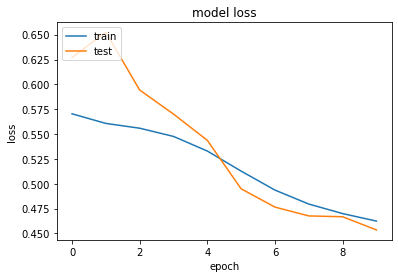

In [26]:
# list all data in history
print(history.history.keys())
# summarize history for accuracy
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

# Prediction

In [27]:
prepared_test = add_neighbours(test, k=3)
X_test = prepared_test.drop(['data_ind'], axis=1)

100%|██████████| 11/11 [00:33<00:00,  3.02s/it]


In [ ]:
#xgb_class.fit(X_train, y_train)
#probas = xgb_class.predict(X_test)
X_test_norm = transformer.transform(X_test.fillna(0))
probas = nn.predict(X_test_norm).squeeze()
probas

In [ ]:
df = pd.DataFrame({'id': prepared_test.index, 'signal': probas}).groupby('id')
agg = df.aggregate(('mean')).loc[:, ['signal']]

In [ ]:
agg.shape

In [ ]:
agg.head()

In [ ]:
agg.to_csv('submission.csv.gz', index=True, compression='gzip')

In [ ]:
# Releasing Memory
prepared_test = None
X_test = None
probas = None
df = None
agg = None
train = None

gc.collect()